<a href="https://colab.research.google.com/github/singh-prishita/MLFinalAssignment/blob/main/Data_Cleaning_Reviews_AirbnbDublin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install deep_translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from langdetect import detect
from deep_translator import GoogleTranslator

from tqdm import tqdm
tqdm.pandas()

from textblob import TextBlob

import seaborn as sns
sns.set_theme(style="whitegrid")

import pickle 

import importlib

import nltk
from nltk.stem import WordNetLemmatizer

from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

from nltk.tokenize import word_tokenize

import itertools

In [ ]:
df_review = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews.csv')

In [ ]:
df_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,44077,203703,2011-03-20,393348,Christian,We enjoyed our stay very much. The room was co...
1,44077,211369,2011-03-28,444004,Solidea,We have been here 4 nights. Stay in a home is ...
2,44077,234215,2011-04-21,465058,Michael And Isabelle,Teresa and Hughie were great hosts. They were ...
3,44077,261843,2011-05-13,490005,Weston,"No surprises, was as described. Very gracious..."
4,44077,268148,2011-05-17,520460,Barbara,"Teresa was a lovely hostess, and we had a deli..."


In [ ]:
print(f'Dataset has {df_review.shape[0]} reviews per {df_review.listing_id.nunique()} listings.')

Dataset has 243183 reviews per 6209 listings.


In [ ]:
# Checking for all the missing or null values

df_review.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

In [ ]:
# Dropping out the rows with missing values

df_review.dropna(inplace=True)
df_review.shape

(243165, 6)

In [ ]:
# Calculating the length of the comments and adding a new column

df_review['length_comments'] = df_review['comments'].apply(lambda x: len(x.split()))

In [ ]:
df_review['length_comments'].max()

1002

In [ ]:
df_review['length_comments'].min()

1

In [ ]:
# Lowercasing all the comments

df_review['comments'] = df_review['comments'].str.lower()
df_review['comments'].head()

0    we enjoyed our stay very much. the room was co...
1    we have been here 4 nights. stay in a home is ...
2    teresa and hughie were great hosts. they were ...
3    no surprises, was as described.  very gracious...
4    teresa was a lovely hostess, and we had a deli...
Name: comments, dtype: object

In [ ]:
# Dropping the  automatic comments where the host cancelled reservation

index_canceled = df_review[df_review["comments"].str.contains("canceled", case=False, na=False)].index
df_review.drop(index_canceled, inplace=True)
df_review.shape

(241287, 7)

In [ ]:
# Removing all the punctuation

df_review['comments'] = df_review['comments'].str.replace('[^\w\s]','',regex=True)
df_review['comments'].head()

0    we enjoyed our stay very much the room was com...
1    we have been here 4 nights stay in a home is t...
2    teresa and hughie were great hosts they were v...
3    no surprises was as described  very gracious h...
4    teresa was a lovely hostess and we had a delig...
Name: comments, dtype: object

In [ ]:
# Removing all emojis

def removing_emoji(text):
    emoji_patterns = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_patterns.sub(r'', text)

df_review['comments'] = df_review['comments'].apply(lambda x: removing_emoji(x))

In [ ]:
# Removing the numbers

df_review['comments'] = df_review['comments'].str.replace(r'[0-9]','',regex=True)

In [ ]:
# Replacing the rows with the empty string with none value and dropping them

df_review['comments'] = df_review.comments.replace(r'^\s*$','none', regex=True)
df_review.drop(df_review[df_review['comments']=='none'].index, inplace = True)

In [ ]:
# Removing the duplicate values if there are any

df_review.comments.drop_duplicates()

0         we enjoyed our stay very much the room was com...
1         we have been here  nights stay in a home is th...
2         teresa and hughie were great hosts they were v...
3         no surprises was as described  very gracious h...
4         teresa was a lovely hostess and we had a delig...
                                ...                        
243178               ottima posizione gentilezza e cortesia
243179    jenny was able to get us in last minute and ex...
243180    very spacious owners communicative only issue ...
243181    what a great host couple and great spot super ...
243182    ana is a lovey host brthere was an issue at  a...
Name: comments, Length: 234342, dtype: object

In [ ]:
# Identifying the language of comments

def safe_detect(x):
    ''' Function detecting language.
    If a language is not identified,
    it returns empty.
    '''
    try:
        lan = detect(x)
    except:
        lan = ""
    return lan

In [ ]:
# Creating a new column 'language'
# NB: safe_detect takes a long time to run

df_review['language'] = df_review['comments'].apply(safe_detect)

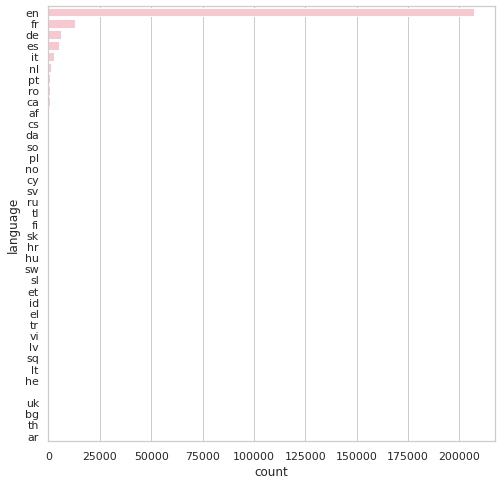

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
sns.set_color_codes("pastel")
sns.countplot(y="language", data=df_review, order = df_review['language'].value_counts(normalize=True).index,
              label="Total", color="pink")
plt.show()

In [ ]:
# Keep records with comments in en, it, fr, es, de, pt, ru

df_review_reduced = df_review['language']

In [ ]:
df_review_reduced = df_review.loc[df_review['language'].isin(['en','it','fr','es','de','pt','ru'])]

In [ ]:
# Save a reduced sample of comments written in en, it, fr, es, de, pt, ru. Other languages are neglible.

df_review_reduced.to_pickle('/content/drive/MyDrive/Colab Notebooks/df_reviews_reduced.pkl')

In [ ]:
df_review_reduced = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/df_reviews_reduced.pkl')

In [ ]:
df_review_reduced.language.value_counts(normalize=True)

en    0.881184
fr    0.054118
de    0.025758
es    0.022761
it    0.011436
pt    0.004219
ru    0.000524
Name: language, dtype: float64

In [ ]:
# Pick a random sample of reviews (30%) preserving the share of languages

sample_df = df_review_reduced.groupby('language').apply(lambda x: x.sample(frac=0.1)).reset_index(level='language', drop=True)

In [ ]:
# Translating the  comments other than English to English
#
def safe_translation(x):
    ''' Function that uses Google Translator 
    to translate comments to English.
    If a language is not identified,
    it returns empty.
    '''
    try:
        sentence = GoogleTranslator(source='auto', target='en').translate(x)
    except:
        print("Failed: ", x)
        sentence = ""
    return sentence

In [ ]:
# Save updated dataset

sample_df.to_pickle('/content/drive/MyDrive/Colab Notebooks/df_reviews_sample.pkl')

In [ ]:
# Check if the dataset correctly uploads

df_review_sample = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/df_reviews_sample.pkl')